# Analyse globale des jeux vidéo disponibles sur la plateforme Steam 👾
## Description de l'entreprise 📇
Steam est un service de distribution numérique de jeux vidéo et une vitrine de Valve . Il a été lancé en tant que logiciel client en septembre 2003 pour fournir automatiquement des mises à jour pour les jeux de Valve, et étendu à la distribution de titres tiers fin 2005. Steam offre diverses fonctionnalités, telles que la gestion des droits numériques (DRM), la mise en relation de serveurs de jeux avec Valve Anti. -Mesures de triche , réseaux sociaux et services de streaming de jeux . Les fonctions du client Steam incluent l'automatisation des mises à jour du jeu, le stockage dans le cloud pour la progression du jeu et des fonctionnalités communautaires telles que la messagerie directe, les fonctions de superposition dans le jeu et un marché virtuel à collectionner .
## Projet 🚧
Nous travaillons pour Ubisoft , un éditeur français de jeux vidéo. Ils aimeraient sortir un nouveau jeu vidéo révolutionnaire ! Ils nous ont demandé de réaliser une analyse globale des jeux disponibles sur la place de marché Steam afin de mieux comprendre l'écosystème du jeu vidéo et les tendances actuelles.
## Objectifs 🎯
Le but ultime de ce projet est de comprendre quels facteurs affectent la popularité ou les ventes d'un jeu vidéo. Mais notre patron nous a demandé de profiter de cette opportunité pour analyser le marché du jeu vidéo à l’échelle mondiale.

Pour mener à bien ce projet, nous avons exploré plusieurs questions susceptibles d'être intéressantes.


## Import des Bibliothèques nécessaires

In [0]:
# Création d'une instance SparkSession appelée "spark"
spark   

# Import les fonctions nécessaires
from pyspark.sql.functions import col, round, substring, split, explode, trim, avg, expr , desc, countDistinct, regexp_extract
import numpy as np
import pandas as pd

# Import la bibliothèque de visualisation de Databricks
import seaborn as sns
import matplotlib.pyplot as plt


## Chargement du jeu de données depuis son URI

In [0]:
steam_rdd = spark.read.json('s3://full-stack-bigdata-datasets/Big_Data/Project_Steam/steam_game_output.json')

## Exploration du jeu de données

In [0]:
# Récupération de la première ligne du dataset dans notre RDD
steam_rdd.take(3)

Out[3]: [Row(data=Row(appid=10, categories=['Multi-player', 'Valve Anti-Cheat enabled', 'Online PvP', 'Shared/Split Screen PvP', 'PvP'], ccu=13990, developer='Valve', discount='0', genre='Action', header_image='https://cdn.akamai.steamstatic.com/steam/apps/10/header.jpg?t=1666823513', initialprice='999', languages='English, French, German, Italian, Spanish - Spain, Simplified Chinese, Traditional Chinese, Korean', name='Counter-Strike', negative=5199, owners='10,000,000 .. 20,000,000', platforms=Row(linux=True, mac=True, windows=True), positive=201215, price='999', publisher='Valve', release_date='2000/11/1', required_age='0', short_description="Play the world's number 1 online action game. Engage in an incredibly realistic brand of terrorist warfare in this wildly popular team-based game. Ally with teammates to complete strategic missions. Take out enemy sites. Rescue hostages. Your role affects your team's success. Your team's success affects your role.", tags=Row(1980s=266, 1990's=1

In [0]:
# Comptage du nombre de ligne dans le dataset
nombre_de_lignes = steam_rdd.count()
print("Nombre de lignes dans le RDD :", nombre_de_lignes)


Nombre de lignes dans le RDD : 55691


In [0]:
# Affichage de la structure du dataset
steam_rdd.printSchema()

root
 |-- data: struct (nullable = true)
 |    |-- appid: long (nullable = true)
 |    |-- categories: array (nullable = true)
 |    |    |-- element: string (containsNull = true)
 |    |-- ccu: long (nullable = true)
 |    |-- developer: string (nullable = true)
 |    |-- discount: string (nullable = true)
 |    |-- genre: string (nullable = true)
 |    |-- header_image: string (nullable = true)
 |    |-- initialprice: string (nullable = true)
 |    |-- languages: string (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- negative: long (nullable = true)
 |    |-- owners: string (nullable = true)
 |    |-- platforms: struct (nullable = true)
 |    |    |-- linux: boolean (nullable = true)
 |    |    |-- mac: boolean (nullable = true)
 |    |    |-- windows: boolean (nullable = true)
 |    |-- positive: long (nullable = true)
 |    |-- price: string (nullable = true)
 |    |-- publisher: string (nullable = true)
 |    |-- release_date: string (nullable = true)
 |    |-

## Analyse globale des jeux vidéo
### Analyse au niveau « macro »

#### Nombre de jeux sortis par éditeur sur Steam

+---------------+-----+
|      publisher|count|
+---------------+-----+
| Big Fish Games|  422|
|         8floor|  202|
|           SEGA|  165|
| Strategy First|  151|
|    Square Enix|  141|
|Choice of Games|  140|
|  Sekai Project|  132|
|       HH-Games|  132|
|               |  132|
|        Ubisoft|  127|
+---------------+-----+



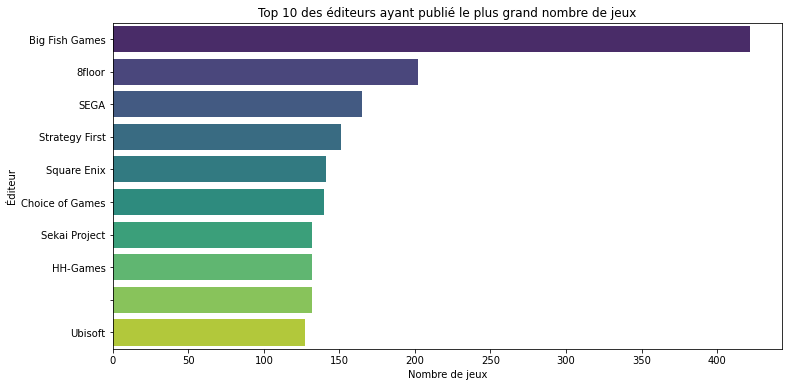

In [0]:
# Fitre de l'éditeur qui a sorti le plus de jeux vidéo
more_games_by_publisher = steam_rdd.groupBy("data.publisher").count().orderBy(col('count').desc()).limit(10)
more_games_by_publisher.show()

# Convertir le résultat en DataFrame Spark
df_more_games_by_publisher = more_games_by_publisher.toPandas()

# Utilisation de la bibliothèque Seaborn pour tracer un graphique à barres
plt.figure(figsize=(12, 6))
sns.barplot(data=df_more_games_by_publisher, x='count', y='publisher', palette='viridis')
plt.xlabel('Nombre de jeux')
plt.ylabel('Éditeur')
plt.title('Top 10 des éditeurs ayant publié le plus grand nombre de jeux')
plt.show()


#### Les jeux les mieux notés

In [0]:
# Sélection des jeux les mieux notés
better_rated_games = steam_rdd.select(
    col('data.name').alias('Nom du jeu'), 
    col('data.appid').alias('Identifiant'), 
    (col('data.positive') / (col('data.positive') + col('data.negative'))).alias('Note')
).orderBy('Note', ascending=False)

# Regroupement des jeux par leur note et compter le nombre de jeux dans chaque groupe
game_counts_by_rating = (better_rated_games
                         .withColumn('Note', round(col('Note'), 1))  # Arrondir les notes à un décimal
                         .groupBy('Note')
                         .count()
                         .orderBy('Note'))
game_counts_by_rating.show()


+----+-----+
|Note|count|
+----+-----+
|null|  163|
| 0.0| 1693|
| 0.1|  261|
| 0.2|  672|
| 0.3| 1940|
| 0.4| 2211|
| 0.5| 4239|
| 0.6| 4907|
| 0.7| 7189|
| 0.8|10198|
| 0.9|10882|
| 1.0|11336|
+----+-----+



+--------------------+-----------+----+
|          Nom du jeu|Identifiant|Note|
+--------------------+-----------+----+
|The Spell - A Kin...|    1002510| 1.0|
|      Twisting Mower|    1001730| 1.0|
|            Diamonds|    1001740| 1.0|
|       Cube Defender|    1000130| 1.0|
|         Next Stop 3|    1001430| 1.0|
|      Rotund Rebound|    1000750| 1.0|
|               N-GON|    1002590| 1.0|
|Zero spring episo...|    1000900| 1.0|
|    Hand of Horzasha|    1002690| 1.0|
|Kooring VR Wonder...|    1001100| 1.0|
|     Magus Over Fool|    1002860| 1.0|
|               GUIDE|    1001570| 1.0|
|      The Truck Game|    1004170| 1.0|
|Twisty Puzzle Sim...|    1002910| 1.0|
|   The Demon Crystal|    1001660| 1.0|
|Symploke: Legend ...|    1002980| 1.0|
|Fist Of Heaven & ...|    1000650| 1.0|
|           CrossTrix|    1003690| 1.0|
|          Kill Tiger|    1000980| 1.0|
|          Aether Way|    1003760| 1.0|
+--------------------+-----------+----+



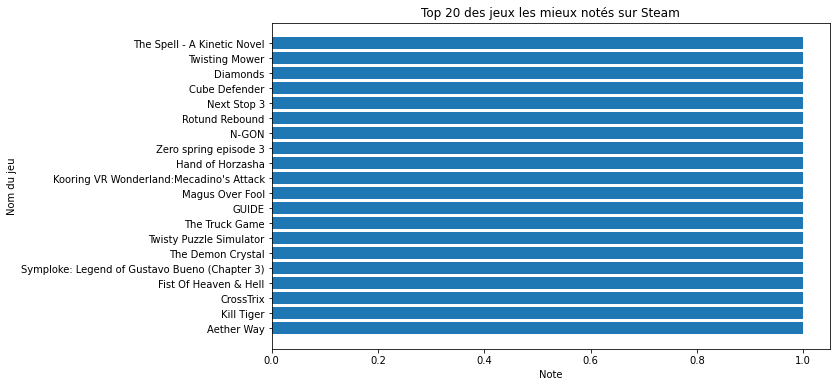

In [0]:
# Sélection des jeux les mieux notés (Top 20)
better_rated_games = steam_rdd.select(
    col('data.name').alias('Nom du jeu'), 
    col('data.appid').alias('Identifiant'), 
    (col('data.positive') / (col('data.positive') + col('data.negative'))).alias('Note')
).orderBy('Note', ascending=False).limit(20)
better_rated_games.show()

# Récupération des données des jeux mieux notés
game_names = better_rated_games.select('Nom du jeu').rdd.flatMap(lambda x: x).collect()
rating = better_rated_games.select('Note').rdd.flatMap(lambda x: x).collect()

# Création du graphique à barres horizontales
plt.figure(figsize=(10, 6))
plt.barh(game_names, rating)
plt.xlabel('Note')
plt.ylabel('Nom du jeu')
plt.title('Top 20 des jeux les mieux notés sur Steam')
plt.gca().invert_yaxis()  # Inversion de l'axe y pour afficher le jeu le mieux noté en haut
plt.show()

#### Le nombre de lancements de jeux vidéo par année.

+----+-----+
|Year|count|
+----+-----+
|2021| 8823|
|2020| 8305|
|2018| 7678|
|2022| 7455|
|2019| 6968|
|2017| 6017|
|2016| 4185|
|2015| 2576|
|2014| 1557|
|2013|  471|
|2012|  345|
|2009|  311|
|2010|  288|
|2011|  267|
|2008|  159|
|    |   99|
|2007|   98|
|2006|   61|
|2005|    6|
|2004|    6|
+----+-----+
only showing top 20 rows



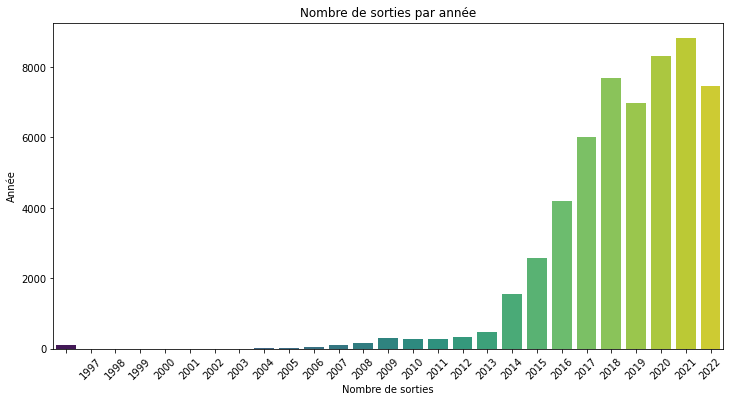

In [0]:
# Filtre du nombre de jeux vidéo sortis par an
years_more_releases = steam_rdd.withColumn("Year", substring("data.release_date", 1, 4)) \
    .groupBy("Year") \
    .count() \
    .orderBy("Count", ascending=False)
years_more_releases.show()

# Convertir le résultat en DataFrame Spark
df_years_more_releases = years_more_releases.toPandas()

# Trier le DataFrame pandas par année (Year) en ordre croissant
df_years_more_releases.sort_values(by='Year', ascending=True, inplace=True)

# Utilisation de la bibliothèque Seaborn pour tracer un graphique à barres
plt.figure(figsize=(12, 6))
sns.barplot(data=df_years_more_releases, x='Year', y='count', palette='viridis')  # Inverser x et y
plt.xlabel('Nombre de sorties')
plt.ylabel('Année')  # Inverser x et y
plt.title('Nombre de sorties par année')
plt.xticks(rotation=45)
plt.show()


#### Distribution des prix et Jeu en Réduction

In [0]:
# Filtre des jeux avec une réduction, y compris ceux avec une réduction de 0
gamesWithDiscount = steam_rdd.filter(col("data.discount").isNotNull() & (col("data.discount") >= 0))
gamesWithDiscountCount = gamesWithDiscount.count()
print("Nombre de jeux avec une réduction :", gamesWithDiscountCount)


Nombre de jeux avec une réduction : 55691


<command-1838745962223086>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  prices_df["Price"] = prices_df["price"].str.replace("$", "").astype(float)


Out[11]: Text(1.4, 0, 'N = 7780')

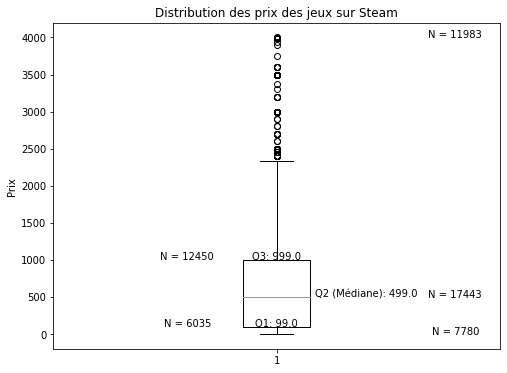

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Sélection des prix des jeux et conversion en Pandas DataFrame
prices_df = steam_rdd.select("data.price").toPandas()

# Suppression des valeurs nulles
prices_df.dropna(inplace=True)

# Conversion des prix en numérique et enlèvement des symboles de monnaie s'ils existent
prices_df["Price"] = prices_df["price"].str.replace("$", "").astype(float)

# Nombre de jeux à zéro
zero_price_count = prices_df[prices_df["Price"] == 0].shape[0]

# Calcul de la moyenne et de l'écart type des prix
mean_price = prices_df["Price"].mean()
std_dev_price = prices_df["Price"].std()

# Définition des bornes pour filtrer les valeurs aberrantes
lower_bound = mean_price - 3 * std_dev_price
upper_bound = mean_price + 3 * std_dev_price

# Filtrage des valeurs aberrantes
filtered_prices_df = prices_df[(prices_df["Price"] >= lower_bound) & (prices_df["Price"] <= upper_bound)]

# Résumé statistique des prix filtrés
summary_stats_filtered = filtered_prices_df["Price"].describe()

# Calcul des quartiles à partir des données filtrées
Q1_filtered = filtered_prices_df["Price"].quantile(0.25)
Q2_filtered = filtered_prices_df["Price"].quantile(0.5)
Q3_filtered = filtered_prices_df["Price"].quantile(0.75)

# Nombre de jeux dans chaque quartile
first_quartile_count = prices_df[(prices_df["Price"] > 0) & (prices_df["Price"] <= Q1_filtered)].shape[0]
second_quartile_count = prices_df[(prices_df["Price"] > Q1_filtered) & (prices_df["Price"] <= Q2_filtered)].shape[0]
third_quartile_count = prices_df[(prices_df["Price"] > Q2_filtered) & (prices_df["Price"] <= Q3_filtered)].shape[0]
fourth_quartile_count = prices_df[prices_df["Price"] > Q3_filtered].shape[0]

# Création du boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(filtered_prices_df["Price"], vert=True)
plt.ylabel('Prix')
plt.title('Distribution des prix des jeux sur Steam')

# Annotation des quartiles sur le boxplot
plt.text(1, Q1_filtered, f'Q1: {Q1_filtered}', horizontalalignment='center')
plt.text(1.2, Q2_filtered, f'Q2 (Médiane): {Q2_filtered}', horizontalalignment='center')
plt.text(1, Q3_filtered, f'Q3: {Q3_filtered}', horizontalalignment='center')

# Affichage du nombre de jeux dans chaque quartile
plt.text(0.8, Q1_filtered, f'N = {first_quartile_count}', horizontalalignment='center')
plt.text(1.4, Q2_filtered, f'N = {second_quartile_count}', horizontalalignment='center')
plt.text(0.8, Q3_filtered, f'N = {third_quartile_count}', horizontalalignment='center')
plt.text(1.4, summary_stats_filtered["max"], f'N = {fourth_quartile_count}', horizontalalignment='center')

# Ajout du nombre de jeux avec un prix de zéro
plt.text(1.4, 0, f'N = {zero_price_count}', horizontalalignment='center')


#### Les langues les plus fréquemment utilisées.

+-------------------+-----+
|          Languages|count|
+-------------------+-----+
|            English|55116|
|             German|14019|
|             French|13426|
|            Russian|12922|
| Simplified Chinese|12782|
|    Spanish - Spain|12233|
|           Japanese|10368|
|            Italian| 9304|
|Portuguese - Brazil| 6750|
|             Korean| 6600|
+-------------------+-----+



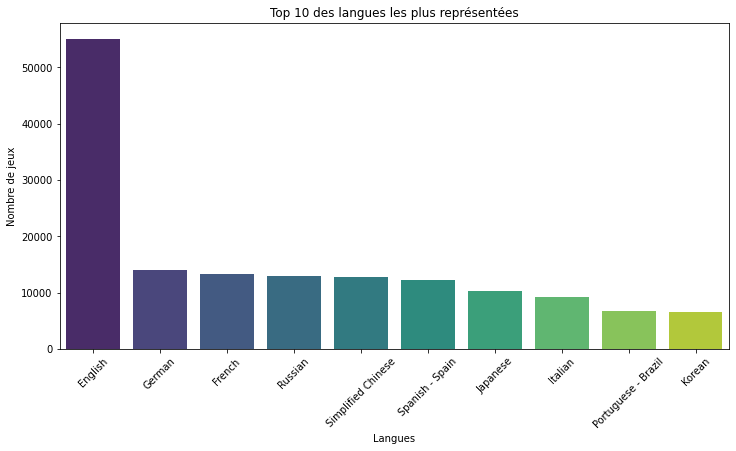

In [0]:
# Sélection des langues les plus fréquentes
languages_most_represented = (steam_rdd
    .withColumn("languages_list", split("data.languages", ","))
    .select(explode("languages_list").alias("Languages"))
    .select(trim(col("Languages")).alias("Languages"))  # Supprime les espaces blancs autour des langues
    .groupBy("Languages")
    .count()
    .orderBy(col("count").desc())
    .limit(10)
)
languages_most_represented.show()

# Convertir le résultat en DataFrame Spark
df_languages_most_represented = languages_most_represented.toPandas()

# Utilisation de la bibliothèque Seaborn pour tracer un graphique à barres
plt.figure(figsize=(12, 6))
sns.barplot(data=df_languages_most_represented, x='Languages', y='count', palette='viridis')  # Inverser x et y
plt.xlabel('Langues')
plt.ylabel('Nombre de jeux')
plt.title('Top 10 des langues les plus représentées')
plt.xticks(rotation=45)
plt.show()

#### Les jeux interdits aux moins de 16/18 ans

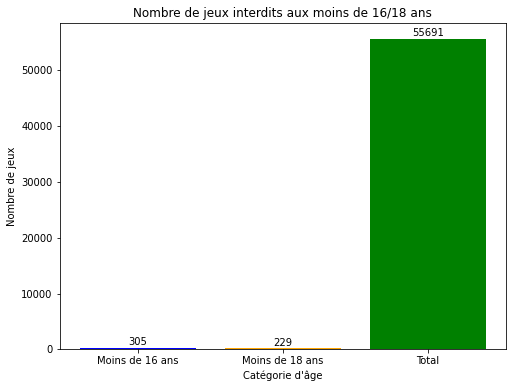

In [0]:
# Sélection des jeux interdits aux moins de 16/18 ans
games_not_permitted_for_minors_16 = steam_rdd.filter(col('data.required_age') >= 16).count()
games_not_permitted_for_minors_18 = steam_rdd.filter(col('data.required_age') >= 18).count()

# Comptage du nombre de lignes dans le dataset
nombre_de_lignes = steam_rdd.count()

# Création du dictionnaire de données sans les valeurs nulles
data = {
    'Catégorie d\'âge': ['Moins de 16 ans', 'Moins de 18 ans', 'Total'],
    'Nombre de jeux': [games_not_permitted_for_minors_16, games_not_permitted_for_minors_18, nombre_de_lignes]
}

# Données
categories = data['Catégorie d\'âge']
nombre_jeux = data['Nombre de jeux']

# Création du graphique
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, nombre_jeux, color=['blue', 'orange', 'green'])
plt.xlabel('Catégorie d\'âge')
plt.ylabel('Nombre de jeux')
plt.title('Nombre de jeux interdits aux moins de 16/18 ans')

# Ajout des chiffres au-dessus des barres
for bar, nombre in zip(bars, nombre_jeux):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 100, str(nombre), ha='center', va='bottom')

plt.show()


### Analyse de genre


#### Les genres de jeu les plus fréquents

+--------------------+-----+
|              Genres|count|
+--------------------+-----+
|               Indie|39681|
|              Action|23759|
|              Casual|22086|
|           Adventure|21431|
|            Strategy|10895|
|          Simulation|10836|
|                 RPG| 9534|
|        Early Access| 6145|
|        Free to Play| 3393|
|              Sports| 2666|
|              Racing| 2155|
|Massively Multipl...| 1460|
|           Utilities|  682|
|Design & Illustra...|  406|
|Animation & Modeling|  322|
|           Education|  317|
|    Video Production|  247|
|    Audio Production|  195|
|             Violent|  168|
|   Software Training|  164|
+--------------------+-----+



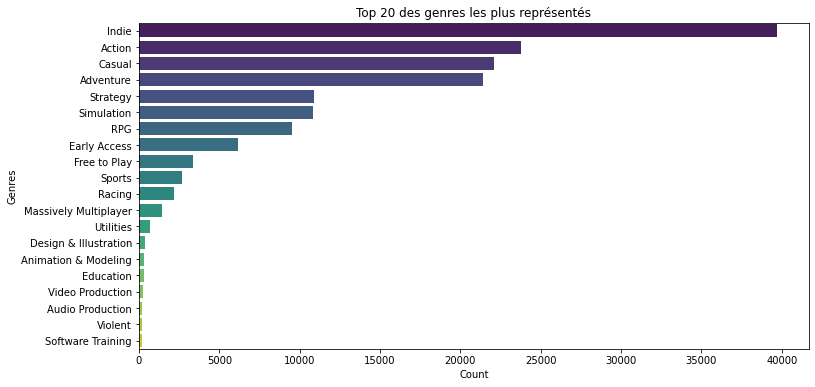

In [0]:
# Sélection des genres les plus représentés.
most_represented_genres = (steam_rdd
    .withColumn("genres_list", split("data.genre", ","))
    .select(explode("genres_list").alias("Genres"))
    .select(trim(col("Genres")).alias("Genres"))  # Supprime les espaces blancs autour des langues
    .groupBy("Genres")
    .count()
    .orderBy(col("count").desc())
    .limit(20)
)
most_represented_genres.show()

# Convertir le résultat en DataFrame Spark
df_most_represented_genres = most_represented_genres.toPandas()

# Utilisation de la bibliothèque Seaborn pour tracer un graphique à barres
plt.figure(figsize=(12, 6))
sns.barplot(data=df_most_represented_genres, x='count', y='Genres', palette='viridis')
plt.xlabel('Count')
plt.ylabel('Genres')
plt.title('Top 20 des genres les plus représentés')
plt.show()



#### Meilleur ratio d'avis positifs/négatifs en fonction du genre

+--------------------+-------------------------+
|              Genres|ratio_moyen_avis_positifs|
+--------------------+-------------------------+
|                 RPG|       0.7721354194673719|
|           Adventure|       0.7696010529568887|
|              Action|       0.7524793322886275|
|               Indie|       0.7514275221007822|
|              Casual|       0.7504825420727897|
|            Strategy|       0.7387058633464376|
|Design & Illustra...|       0.7049599091362624|
|        Free to Play|       0.6982428393113599|
|              Racing|       0.6978865233883265|
|           Utilities|       0.6959156815539256|
|Animation & Modeling|       0.6878283520019279|
|          Simulation|       0.6772077224901205|
|Massively Multipl...|       0.6726812244143793|
|           Education|        0.657631958965452|
|        Early Access|       0.6507988542193549|
|    Audio Production|       0.6393881724397946|
|              Sports|       0.6195988769561833|
|   Software Trainin

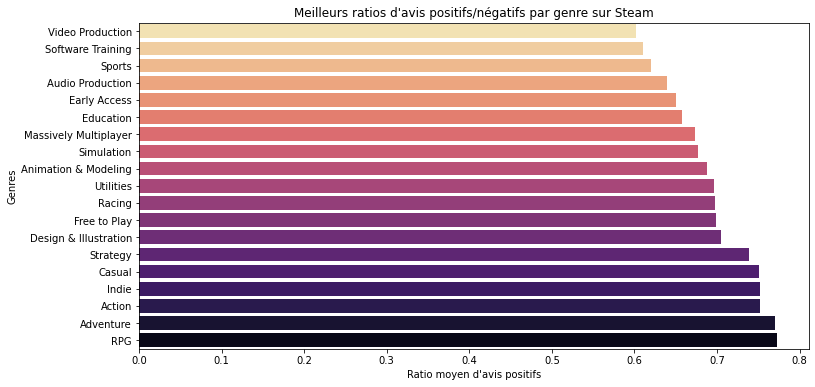

In [0]:
# Selection des meilleurs ratio d'avis positifs/négatifs en fonction du genre
genres_ratio_avis = (steam_rdd
    .withColumn('positive_ratio', col('data.positive') / (col('data.positive') + col('data.negative')))
    .join(most_represented_genres, most_represented_genres["Genres"] == col("data.genre"), "inner")
    .groupBy("Genres") 
    .agg(avg("positive_ratio").alias("ratio_moyen_avis_positifs"))
    .orderBy(col("ratio_moyen_avis_positifs").desc())
    .limit(20)
)
genres_ratio_avis.show()

# Convertir le résultat en DataFrame Spark
df_genres_ratio_avis = genres_ratio_avis.toPandas()

# Utilisation de la bibliothèque Seaborn pour tracer un graphique à barres
plt.figure(figsize=(12, 6))
sns.barplot(data=df_genres_ratio_avis, x='ratio_moyen_avis_positifs', y='Genres', palette='magma')  
plt.xlabel('Ratio moyen d\'avis positifs')
plt.ylabel('Genres')
plt.title('Meilleurs ratios d\'avis positifs/négatifs par genre sur Steam')
plt.gca().invert_yaxis() 
plt.show()



#### Genres favoris des éditeurs

In [0]:
# compte du nombres d'éditeurs distincts 
nombre_editeurs = steam_rdd.select("data.publisher").distinct().count()
print("Nombre d'éditeurs distincts :", nombre_editeurs)

Nombre d'éditeurs distincts : 29966


In [0]:
# Sélection des genres les plus représentés avec la colonne "publisher"
most_represented_genres_with_publisher = (steam_rdd
    .select("data.publisher", explode(split("data.genre", ",")).alias("genre"))
    .select("publisher", trim(col("genre")).alias("genre"))
    .groupBy("publisher", "genre")
    .count()
    .orderBy(col("count").desc())
)

# Regroupement par genre et comptage du nombre d'éditeurs distincts pour chaque genre
genre_publisher_counts = (most_represented_genres_with_publisher
    .groupBy("genre")
    .agg(countDistinct("publisher").alias("num_publishers"))
    .orderBy(desc("num_publishers"))
)

top_10_genres = genre_publisher_counts.limit(10)
top_10_genres.show()


+------------+--------------+
|       genre|num_publishers|
+------------+--------------+
|       Indie|         24039|
|      Action|         15429|
|   Adventure|         12828|
|      Casual|         12751|
|    Strategy|          7047|
|  Simulation|          6902|
|         RPG|          6365|
|Early Access|          5712|
|Free to Play|          2816|
|      Sports|          1868|
+------------+--------------+



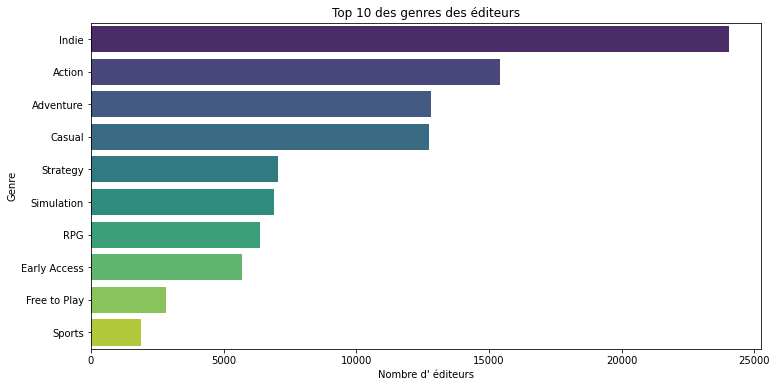

In [0]:
# Convertir le résultat en DataFrame Spark
df_top_10_genres = top_10_genres.toPandas()

# Utilisation de la bibliothèque Seaborn pour tracer un graphique à barres
plt.figure(figsize=(12, 6))
sns.barplot(data=df_top_10_genres, x='num_publishers', y='genre', palette='viridis')
plt.xlabel('Nombre d\' éditeurs')
plt.ylabel('Genre')
plt.title('Top 10 des genres des éditeurs')
plt.show()

#### Les Genres lucratifs

+----------+-------------+
|    Genres|total_revenue|
+----------+-------------+
|    Action|  25248104862|
|       RPG|  11193604504|
|  Strategy|   6309902366|
| Adventure|   1792941883|
|Simulation|   1501856865|
|    Racing|   1079912098|
|     Indie|    735579508|
|    Casual|    456144473|
| Utilities|     62519810|
|    Sports|     31932650|
+----------+-------------+



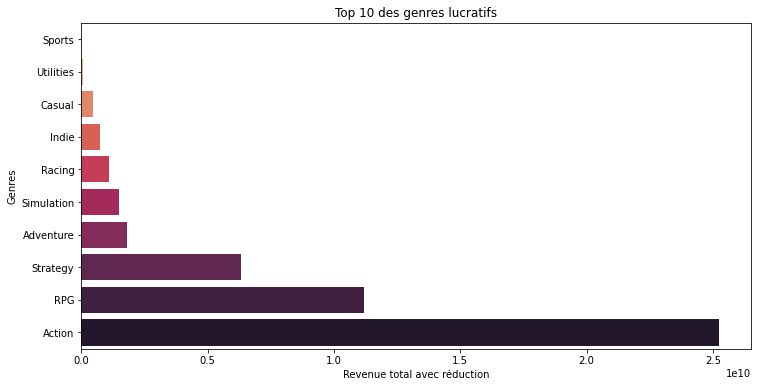

In [0]:
# Nettoyage du prix en ne gardant que les chiffres
steam_rdd = steam_rdd.withColumn('clean_price', regexp_extract('data.price', r'(\d+)', 1))

# Calcul du revenu en utilisant les données nettoyées et en soustrayant la réduction du prix initial
lucrative_genres = (steam_rdd
    .withColumn('Revenue', (col('clean_price').cast('int') - col('data.discount').cast('int')) * (col('data.positive') + col('data.negative')))
    .join(most_represented_genres, most_represented_genres["Genres"] == col("data.genre"), "inner")            
    .groupBy('Genres')
    .agg(expr('sum(Revenue)').alias('total_revenue'))
    .orderBy(col('total_revenue').desc())
    .limit(10)
)
lucrative_genres.show()

# Convertir le résultat en DataFrame Spark
df_lucrative_genres = lucrative_genres.toPandas()

# Utilisation de la bibliothèque Seaborn pour tracer un graphique à barres
plt.figure(figsize=(12, 6))
sns.barplot(data=df_lucrative_genres, x='total_revenue', y='Genres', palette='rocket')  
plt.xlabel('Revenue total avec réduction')
plt.ylabel('Genres')
plt.title('Top 10 des genres lucratifs')
plt.gca().invert_yaxis() 
plt.show()

###Analyse de la plateforme


#### Système d'exploitation des jeux

In [0]:
# Sélection des système d'exploitation des jeux

# Création des expressions conditionnelles pour chaque plateforme
linux_expr = expr("IF(data.platforms.linux, 1, 0)")
mac_expr = expr("IF(data.platforms.mac, 1, 0)")
windows_expr = expr("IF(data.platforms.windows, 1, 0)")

# Sélection et addition des résultats des expressions conditionnelles
platform_counts = steam_rdd.select(
    linux_expr.alias("linux"),
    mac_expr.alias("mac"),
    windows_expr.alias("windows")
).groupBy().sum()
platform_counts.show()

+----------+--------+------------+
|sum(linux)|sum(mac)|sum(windows)|
+----------+--------+------------+
|      8458|   12770|       55676|
+----------+--------+------------+



#### Préférence de genre en fonction de la plateforme

In [0]:
# Sélectionner la colonne "genre" et transformer la colonne "platforms" en un tableau de paires (plateforme, disponibilité)
genre_platform_df = steam_rdd.select("data.genre", explode(expr("map('linux', data.platforms.linux, 'mac', data.platforms.mac, 'windows', data.platforms.windows)")).alias("platform", "availability"))

# Filtrer pour ne récupérer que les jeux disponibles sur une plateforme
available_games_df = genre_platform_df.filter(col("availability"))

# Joindre les données des genres les plus représentés avec les données des plateformes pour chaque jeu
genre_platform_df = available_games_df.join(most_represented_genres, most_represented_genres["Genres"] == col("genre"), "inner")

# Grouper par genre et plateforme, puis compter le nombre de jeux dans chaque catégorie
genre_platform_counts = genre_platform_df.groupBy("Genres", "platform").count()

genre_platform_counts_sorted = genre_platform_counts.orderBy(col("count").desc())

# Afficher les résultats
genre_platform_counts_sorted.show()


+----------+--------+-----+
|    Genres|platform|count|
+----------+--------+-----+
|     Indie| windows| 1755|
|    Action| windows| 1632|
|    Casual| windows| 1433|
| Adventure| windows| 1020|
|  Strategy| windows|  779|
|Simulation| windows|  578|
|       RPG| windows|  534|
|     Indie|     mac|  431|
|    Casual|     mac|  294|
|     Indie|   linux|  276|
| Adventure|     mac|  232|
|  Strategy|     mac|  214|
|    Action|     mac|  209|
| Utilities| windows|  197|
|    Racing| windows|  172|
|    Action|   linux|  155|
|    Casual|   linux|  122|
| Adventure|   linux|  122|
|    Sports| windows|  110|
|  Strategy|   linux|  110|
+----------+--------+-----+
only showing top 20 rows



In [0]:
# Filtrer les données pour chaque plateforme
windows_genres = genre_platform_counts_sorted.filter(col("platform") == "windows")
linux_genres = genre_platform_counts_sorted.filter(col("platform") == "linux")
mac_genres = genre_platform_counts_sorted.filter(col("platform") == "mac")

# Afficher les genres préférant Windows
print("Genres préférant Windows :")
windows_genres.show()

# Afficher les genres préférant Linux
print("Genres préférant Linux :")
linux_genres.show()

# Afficher les genres préférant Mac
print("Genres préférant Mac :")
mac_genres.show()


Genres préférant Windows :
+--------------------+--------+-----+
|              Genres|platform|count|
+--------------------+--------+-----+
|               Indie| windows| 1755|
|              Action| windows| 1632|
|              Casual| windows| 1433|
|           Adventure| windows| 1020|
|            Strategy| windows|  779|
|          Simulation| windows|  578|
|                 RPG| windows|  534|
|           Utilities| windows|  197|
|              Racing| windows|  172|
|              Sports| windows|  110|
|           Education| windows|   93|
|        Free to Play| windows|   54|
|    Video Production| windows|   45|
|    Audio Production| windows|   41|
|Design & Illustra...| windows|   30|
|   Software Training| windows|   22|
|Animation & Modeling| windows|   20|
|        Early Access| windows|   19|
|Massively Multipl...| windows|    7|
+--------------------+--------+-----+

Genres préférant Linux :
+--------------------+--------+-----+
|              Genres|platform|coun

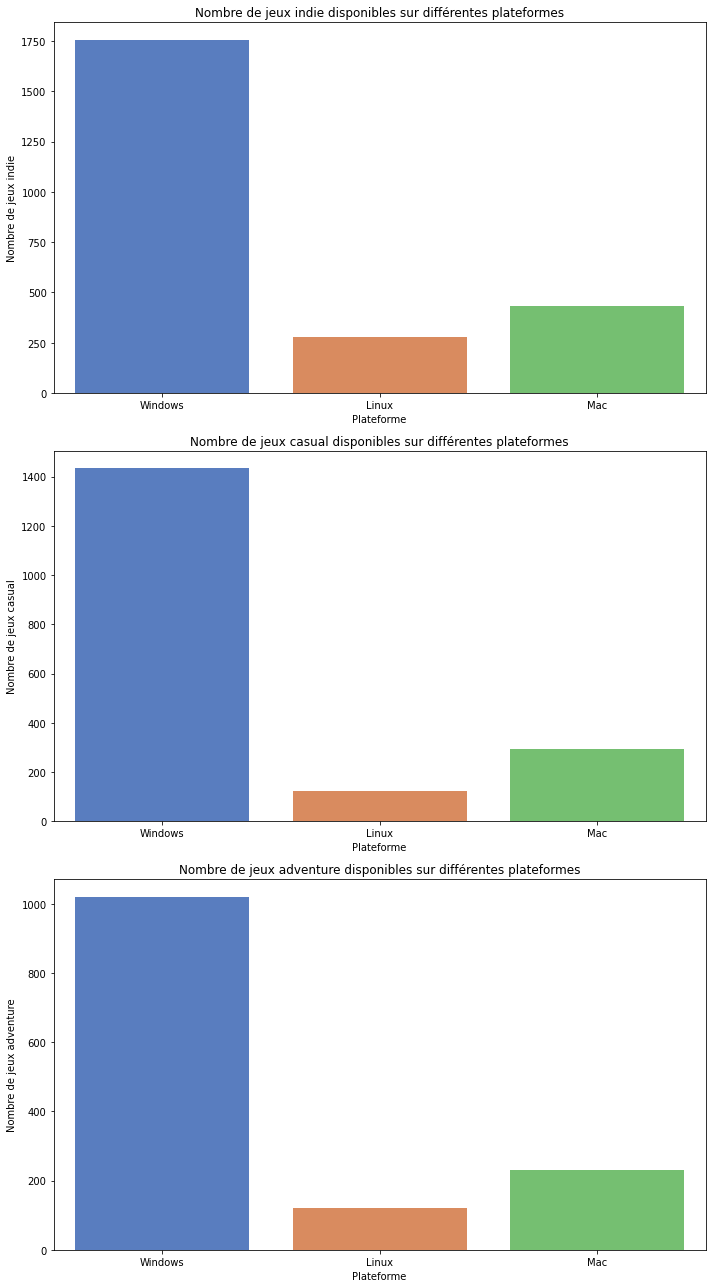

In [0]:
# Liste des genres à visualiser
genres = ["Indie", "Casual", "Adventure"]

# Créer une figure avec des sous-graphiques
fig, axs = plt.subplots(len(genres), 1, figsize=(10, len(genres)*6))

# Boucle sur les genres
for i, genre in enumerate(genres):
    # Filtrer les résultats pour le genre actuel
    genre_counts = genre_platform_counts_sorted.filter(col("Genres") == genre)
    
    # Sélectionner les données pour Windows, Linux et Mac
    windows_data = genre_counts.filter(col("platform") == "windows").select("count").collect()[0][0]
    linux_data = genre_counts.filter(col("platform") == "linux").select("count").collect()[0][0]
    mac_data = genre_counts.filter(col("platform") == "mac").select("count").collect()[0][0]
    
    # Créer un graphique à barres pour le genre actuel
    platforms = ['Windows', 'Linux', 'Mac']
    counts = [windows_data, linux_data, mac_data]
    sns.barplot(x=platforms, y=counts, palette='muted', ax=axs[i])
    axs[i].set_xlabel('Plateforme')
    axs[i].set_ylabel(f'Nombre de jeux {genre.lower()}')
    axs[i].set_title(f'Nombre de jeux {genre.lower()} disponibles sur différentes plateformes')

# Ajuster les marges et afficher les graphiques
plt.tight_layout()
plt.show()
